## Exercise MovieLens 电影数据挖掘
北京大学 胡俊峰 2023-04-10

#### 读取数据

- 1. user数， movies数目， 决定了rating矩阵大小

In [5]:
import numpy as np
import pandas as pd
# Reading ratings file
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('data/users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [6]:
ratings[int(1e6):int(1e6+10)]

,user_id,movie_id,rating,timestamp
1000000,6040,3552,2,956715942
1000001,6040,1952,5,957717017
1000002,6040,1954,3,960972782
1000003,6040,25,3,957717322
1000004,6040,348,2,956704972
1000005,6040,29,4,960972720
1000006,6040,1960,4,956715597
1000007,6040,1961,4,956703977
1000008,6040,1962,3,956715569
1000009,6040,1963,4,960972887


In [34]:
ratings_user_stats = ratings.groupby('user_id')['rating'].mean().reset_index()  # 括号！
ratings_user_stats.head()

,user_id,rating
0,1,4.188679
1,2,3.713178
2,3,3.901961
3,4,4.190476
4,5,3.146465


In [170]:
ratings_user_stats2 = ratings.groupby('user_id').agg({'rating':'mean','movie_id':'count'})
ratings_user_stats2

,rating,movie_id
user_id,,
1,4.188679,53
2,3.713178,129
3,3.901961,51
4,4.190476,21
5,3.146465,198
...,...,...
6036,3.302928,888
6037,3.717822,202
6038,3.800000,20


In [98]:
ratings_user_stats2.rename(columns={'rating':'rating_average','movie_id':'movie_count'}, inplace = True)
ratings_user_stats2.describe()

,rating_average,movie_count
count,6040.000000,6040.000000
mean,3.702705,165.597517
std,0.429622,192.747029
min,1.015385,20.000000
25%,3.444444,44.000000
50%,3.735294,96.000000
75%,4.000000,208.000000
max,4.962963,2314.000000


In [99]:
ratings_user_stats2[ratings_user_stats2['movie_count'] > 1300] # 标准化？

,rating_average,movie_count
user_id,,
889,2.840580,1518
1150,2.590630,1302
1181,2.815911,1521
1680,3.555676,1850
1941,3.054545,1595
2063,2.945578,1323
3618,3.008185,1344
4169,3.551858,2314
4277,4.134825,1743


In [100]:
ratings_movie_statis = ratings.groupby('movie_id').agg({'rating':'mean','user_id':'count'})
ratings_movie_statis.rename(columns={'rating':'rating_average','user_id':'user_count'}, inplace = True)
ratings_movie_statis   # reset_index()?

,rating_average,user_count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296
...,...,...
3948,3.635731,862
3949,4.115132,304
3950,3.666667,54


In [101]:
ratings_movie_statis.describe() # 分数直接用预测量？+ kalman

,rating_average,user_count
count,3706.000000,3706.000000
mean,3.238892,269.889099
std,0.672925,384.047838
min,1.000000,1.000000
25%,2.822705,33.000000
50%,3.331546,123.500000
75%,3.740741,350.000000
max,5.000000,3428.000000


In [103]:
pop_junk_moives = ratings_movie_statis[(ratings_movie_statis['rating_average'] < 3) & (ratings_movie_statis['user_count']>780)]
pop_junk_moives

,rating_average,user_count
movie_id,,
788,2.995781,948
1377,2.976722,1031
1391,2.900372,1074
2054,2.933014,1045
2369,2.954762,840
2701,2.158537,902
3354,2.595208,793


In [104]:
pop_golden_moives = ratings_movie_statis[(ratings_movie_statis['rating_average'] > 4.45) & (ratings_movie_statis['user_count']>900)]
pop_golden_moives

,rating_average,user_count
movie_id,,
50,4.517106,1783
260,4.453694,2991
318,4.554558,2227
527,4.510417,2304
858,4.524966,2223
904,4.476190,1050
1198,4.477725,2514


In [107]:
junk_gener_distri = pop_junk_moives.join(movies,on = 'movie_id',how = 'left' ) # index join
junk_gener_distri 

,rating_average,user_count,movie_id,title,genres
movie_id,,,,,
788,2.995781,948,798,Daylight (1996),Action|Adventure|Thriller
1377,2.976722,1031,1398,In Love and War (1996),Romance|War
1391,2.900372,1074,1414,Mother (1996),Comedy
2054,2.933014,1045,2123,All Dogs Go to Heaven (1989),Animation|Children's
2369,2.954762,840,2438,Outside Ozona (1998),Drama|Thriller
2701,2.158537,902,2770,Bowfinger (1999),Comedy
3354,2.595208,793,3423,School Daze (1988),Drama


In [108]:
junk_gener_distri =  pop_junk_moives.merge(movies, left_on = 'movie_id', right_on ='movie_id')
junk_gener_distri 

,movie_id,rating_average,user_count,title,genres
0,788,2.995781,948,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
1,1377,2.976722,1031,Batman Returns (1992),Action|Adventure|Comedy|Crime
2,1391,2.900372,1074,Mars Attacks! (1996),Action|Comedy|Sci-Fi|War
3,2054,2.933014,1045,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
4,2369,2.954762,840,Desperately Seeking Susan (1985),Comedy|Romance
5,2701,2.158537,902,Wild Wild West (1999),Action|Sci-Fi|Western
6,3354,2.595208,793,Mission to Mars (2000),Sci-Fi


In [109]:
golden_gener_distri =  pop_golden_moives.merge(movies, left_on = 'movie_id', right_on ='movie_id')
golden_gener_distri 

,movie_id,rating_average,user_count,title,genres
0,50,4.517106,1783,"Usual Suspects, The (1995)",Crime|Thriller
1,260,4.453694,2991,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,318,4.554558,2227,"Shawshank Redemption, The (1994)",Drama
3,527,4.510417,2304,Schindler's List (1993),Drama|War
4,858,4.524966,2223,"Godfather, The (1972)",Action|Crime|Drama
5,904,4.476190,1050,Rear Window (1954),Mystery|Thriller
6,1198,4.477725,2514,Raiders of the Lost Ark (1981),Action|Adventure


In [110]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [117]:
pop_junk_moives2 = ratings_movie_statis[(ratings_movie_statis['rating_average'] < 3) & (ratings_movie_statis['user_count']>500)]
pop_junk_moives2.describe()

,rating_average,user_count
count,38.000000,38.000000
mean,2.724516,658.210526
std,0.230072,157.524114
min,2.158537,511.000000
25%,2.622278,563.250000
50%,2.763277,602.000000
75%,2.904739,663.000000
max,2.995781,1074.000000


In [118]:
pop_junk_moives2

,rating_average,user_count
movie_id,,
95,2.876176,638
153,2.642214,777
160,2.238938,565
173,2.308511,564
185,2.869947,569
196,2.823636,550
208,2.631336,651
435,2.606004,533
442,2.992188,640


In [120]:
pop_junk_moives2['user_count'].sum()

25012

In [115]:
junk_moive_users = ratings.merge(pop_junk_moives2, left_on ='movie_id', right_on = 'movie_id', how = 'inner')
junk_moive_users

,user_id,movie_id,rating,timestamp,rating_average,user_count
0,2,3257,3,978300073,2.859425,626
1,8,3257,3,978247143,2.859425,626
2,18,3257,2,978153771,2.859425,626
3,22,3257,1,978136958,2.859425,626
4,26,3257,4,978139867,2.859425,626
...,...,...,...,...,...,...
25007,5636,3697,3,959053960,2.867807,643
25008,5682,3697,4,959043421,2.867807,643
25009,5714,3697,3,959223406,2.867807,643
25010,5767,3697,3,959620056,2.867807,643


In [121]:
junk_moive_users_distri = junk_moive_users.merge(users, left_on ='user_id', right_on = 'user_id', how = 'left')
junk_moive_users_distri

,user_id,movie_id,rating,timestamp,rating_average,user_count,gender,zipcode,age_desc,occ_desc
0,2,3257,3,978300073,2.859425,626,M,70072,56+,self-employed
1,8,3257,3,978247143,2.859425,626,M,11413,25-34,programmer
2,18,3257,2,978153771,2.859425,626,F,95825,18-24,clerical/admin
3,22,3257,1,978136958,2.859425,626,M,53706,18-24,scientist
4,26,3257,4,978139867,2.859425,626,M,23112,25-34,executive/managerial
...,...,...,...,...,...,...,...,...,...,...
25007,5636,3697,3,959053960,2.867807,643,M,98102,25-34,executive/managerial
25008,5682,3697,4,959043421,2.867807,643,M,23455-4959,18-24,other or not specified
25009,5714,3697,3,959223406,2.867807,643,M,96753,35-44,artist
25010,5767,3697,3,959620056,2.867807,643,M,75287,25-34,artist


In [129]:
show_distri = junk_moive_users_distri.groupby('occ_desc').agg({'movie_id':'count'})
show_distri

,movie_id
occ_desc,
K-12 student,909
academic/educator,1707
artist,1076
clerical/admin,675
college/grad student,3755
customer service,687
doctor/health care,804
executive/managerial,2381
farmer,78


In [130]:
user_occ_distri = users.groupby('occ_desc').agg({'user_id':'count'})
user_occ_distri

,user_id
occ_desc,
K-12 student,195
academic/educator,528
artist,267
clerical/admin,173
college/grad student,759
customer service,112
doctor/health care,236
executive/managerial,679
farmer,17


In [166]:
show_distri_freq = show_distri.merge(user_occ_distri, left_on ='occ_desc', right_on = 'occ_desc', how = 'inner')
show_distri_freq['freq'] = show_distri_freq['movie_id'] / show_distri_freq['user_id']
show_distri_freq.sort_values('freq',inplace = True)
show_distri_freq

,movie_id,user_id,freq
occ_desc,,,
retired,194,142,1.366197
homemaker,225,92,2.445652
lawyer,375,129,2.906977
academic/educator,1707,528,3.232955
doctor/health care,804,236,3.406780
executive/managerial,2381,679,3.506627
scientist,543,144,3.770833
clerical/admin,675,173,3.901734
artist,1076,267,4.029963


<AxesSubplot:ylabel='occ_desc'>

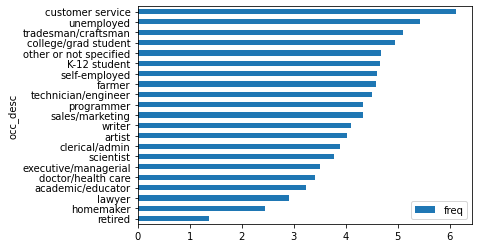

In [167]:
show_distri_freq.plot.barh( y ='freq')